Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [53]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [118]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train")
data_dir_test = pathlib.Path('gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2264
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
num_class = 9

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2264 files belonging to 9 classes.
Using 1812 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2264 files belonging to 9 classes.
Using 452 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

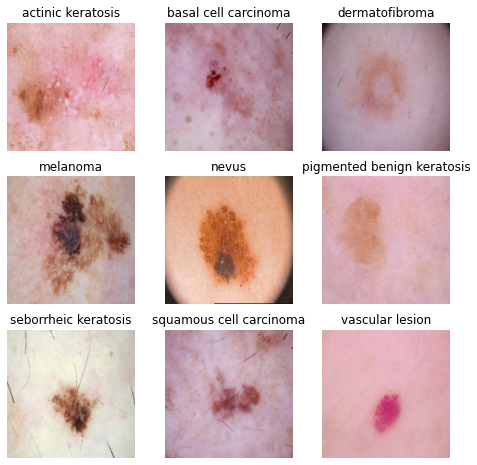

In [9]:
### your code goes here, you can use training or validation data to visualize
fig = plt.figure(figsize=(8,8))
class_int = [ x for x in range(len(class_names))]
for i in range(len(class_names)):
    filtered = val_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered.take(1):
      for l in set(label.numpy()):
        if l in class_int:
          ax = plt.subplot(3, 3, l+1)
          indx = np.where(label.numpy()[:]==l)
          plt.imshow(image[indx[0][0]].numpy().astype('uint8'))
          plt.title(class_names[label.numpy()[indx[0][0]]])
          plt.axis('off')
          class_int.remove(l)
      if len(class_int) == 0:
        break
    if len(class_int) == 0:
        break
      
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# model
model = Sequential([layers.Rescaling(scale=1./255),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_class, activation='softmax')
                  ])




### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.build(input_shape=(32,180,180,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 180, 180, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 90, 90, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 90, 90, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 45, 45, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 45, 45, 64)          1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 189s 81ms/step - loss: 1.8964 - accuracy: 0.3063 - val_loss: 1.6275 - val_accuracy: 0.4425
Epoch 2/20
57/57 [==============================] - 1s 24ms/step - loss: 1.5513 - accuracy: 0.4586 - val_loss: 1.4680 - val_accuracy: 0.4845
Epoch 3/20
57/57 [==============================] - 1s 23ms/step - loss: 1.3994 - accuracy: 0.5210 - val_loss: 1.4117 - val_accuracy: 0.5066
Epoch 4/20
57/57 [==============================] - 1s 23ms/step - loss: 1.3309 - accuracy: 0.5276 - val_loss: 1.4462 - val_accuracy: 0.4801
Epoch 5/20
57/57 [==============================] - 1s 23ms/step - loss: 1.2389 - accuracy: 0.5624 - val_loss: 1.4905 - val_accuracy: 0.4535
Epoch 6/20
57/57 [==============================] - 1s 23ms/step - loss: 1.1364 - accuracy: 0.6076 - val_loss: 1.3548 - val_accuracy: 0.5177
Epoch 7/20
57/57 [==============================] - 1s 23ms/step - loss: 1.0541 - accuracy: 0.6231 - val_loss: 1.3111 - val_accuracy: 0.5000
Epoch 8/20


### Visualizing training results

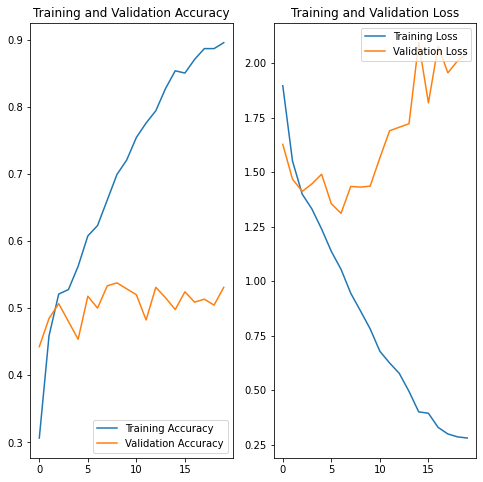

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

It can be observed from the result above of the model fit history that the model seems to be overfitting. This is because it performs well on the training data but significantly poorer on the validation data set. In addition, we can see that there was even a slight drop in the accuracy on the training data between the 19th and 20th epoch which indicates that there is not anymore improvement to be derived by increasing the number of epochs.

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
augument_model = Sequential(
    [
     layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
     layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

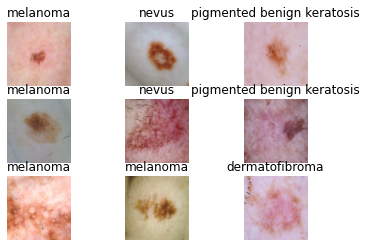

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
  
for i in range(len(class_names)):
  for img, label in train_ds.take(1):
    image = augument_model(img);
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')
plt.show()



### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
                    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                    layers.experimental.preprocessing.RandomRotation(0.2),

                    layers.Rescaling(scale=1./255),

                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),

                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),

                    layers.Dropout(0.25),

                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),

                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),

                    layers.Dropout(0.25),

                    layers.Dense(num_class, activation='softmax')
                  ])



### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# View the summary of all layers
model.build(input_shape=(32,180,180,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (32, 180, 180, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (32, 180, 180, 3)        0         
 tation)                                                         
                                                                 
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 180, 180, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 90, 90, 16)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 90, 90, 32)         

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 3s 29ms/step - loss: 2.2840 - accuracy: 0.1998 - val_loss: 2.1249 - val_accuracy: 0.1903
Epoch 2/20
57/57 [==============================] - 1s 26ms/step - loss: 1.9284 - accuracy: 0.2792 - val_loss: 1.8722 - val_accuracy: 0.3274
Epoch 3/20
57/57 [==============================] - 1s 26ms/step - loss: 1.7795 - accuracy: 0.3604 - val_loss: 1.7433 - val_accuracy: 0.3673
Epoch 4/20
57/57 [==============================] - 1s 26ms/step - loss: 1.7347 - accuracy: 0.3769 - val_loss: 1.6642 - val_accuracy: 0.3739
Epoch 5/20
57/57 [==============================] - 1s 26ms/step - loss: 1.6077 - accuracy: 0.4172 - val_loss: 1.6851 - val_accuracy: 0.3783
Epoch 6/20
57/57 [==============================] - 1s 26ms/step - loss: 1.5582 - accuracy: 0.4487 - val_loss: 1.5170 - val_accuracy: 0.4646
Epoch 7/20
57/57 [==============================] - 1s 26ms/step - loss: 1.5360 - accuracy: 0.4663 - val_loss: 1.5187 - val_accuracy: 0.4889
Epoch 8/20
57

### Visualizing the results

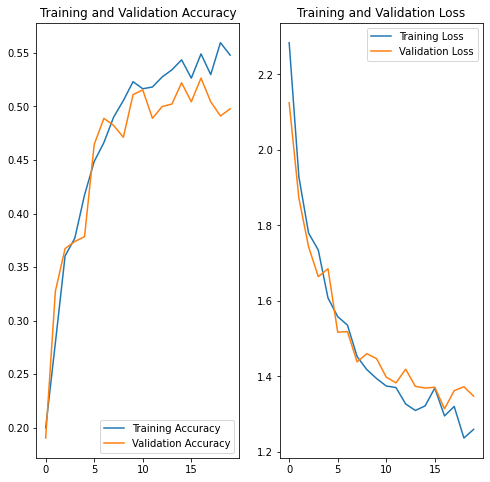

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

From the results, it can be observed that the model is underfitting. We can com to this conclusion becuause we can observe a significantly low accuracy in the prediction using the training data set as well as the validation data set. It is also observed that the difference in the accuracy between training and validation data is not significantly high compared to disparity observed in the initial model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [41]:
## Your code goes here.
class_dist = np.zeros(9)
for i in train_ds.as_numpy_iterator():
  for x in i[1]:
    class_dist[x] +=1
print(class_dist)

[ 88. 317.  83. 355. 278. 377.  60. 135. 119.]


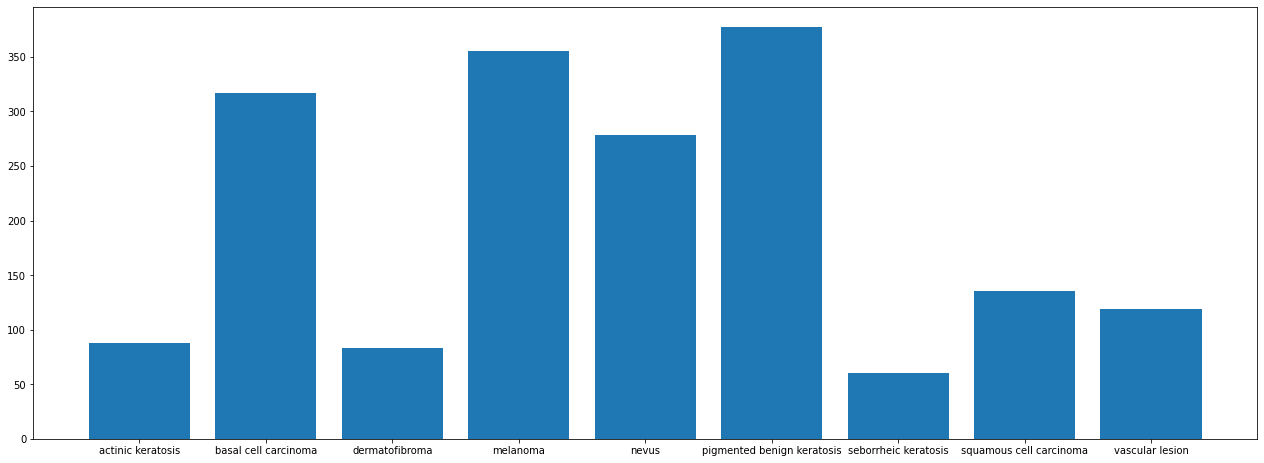

In [40]:
fig = plt.figure(figsize=(17, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(class_names,class_dist)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


- From the class distribution and Figure above, it can be clearly seen that **seborrheic keratosis** has the lowest number of samples which is **60**.

- Also, it can be observed that the following classes dominate the data with proportionately equal ranges of sample count.
  - basal cell carcinoma
  - melanoma
  - nevus
  - pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E2B825690>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 389 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E2B9A4210>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 105 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E2BA1BE90>: 100%|██████████| 500/500 [00:19<00:00, 26.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5E2B946F10>: 100%|██████████| 500/500 [01:35<00:00,  5.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5F5C8219D0>: 100%|██████████| 500/500 [01:19<00:00,  6.30 Samples/s]


Initialised with 464 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E2BA199D0>: 100%|██████████| 500/500 [00:18<00:00, 27.36 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5E2BC1E5D0>: 100%|██████████| 500/500 [00:45<00:00, 10.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5E2BDD1990>: 100%|██████████| 500/500 [00:18<00:00, 27.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E2BD33A50>:  85%|████████▌ | 426/500 [00:15<00:02, 27.05 Samples/s]

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [48]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [66]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanoma_original_ISIC_0010245.jpg_70b003ff-138c-4884-9fc1-abe61fd907a0.jpg',
 'gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanoma_original_ISIC_0000314.jpg_3affb267-626d-4c4d-b9ff-e86a594de79f.jpg',
 'gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanoma_original_ISIC_0011095.jpg_999c1226-c001-4906-8482-d0da7fceaaec.jpg',
 'gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanoma_original_ISIC_0000462.jpg_bc149c53-0d9b-4dc4-a6dc-996cdd5e11d6.jpg',
 'gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanoma_original_ISIC_0011032.jpg_d7f53d3e-6357-422e-9479-7a9714ae64b4.jpg',
 'gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanoma_original_ISIC_0000159.jpg_2bec280f-3822-4ef4-a8b4-75f04f6af7e1.jpg',
 'gdrive/MyDrive/ML_AI/CNNs/Melanoma_Assignment/data/Train/melanoma/output/melanom

In [56]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [97]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [113]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [114]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [115]:
new_df['Label'].value_counts()

pigmented benign keratosis    964
melanoma                      938
basal cell carcinoma          889
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                605
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [116]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [119]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6764 files belonging to 9 classes.
Using 5412 files for training.


#### **Todo:** Create a validation dataset

In [120]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6764 files belonging to 9 classes.
Using 1352 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [121]:
## your code goes here
model = Sequential([
                    layers.Rescaling(scale=1./255),

                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),

                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),

                    layers.Dropout(0.25),

                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),

                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),

                    layers.Dropout(0.25),

                    layers.Dense(num_class, activation='softmax')
                  ])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [122]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# View the summary of all layers
model.build(input_shape=(32,180,180,3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 180, 180, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 90, 90, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 90, 90, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 45, 45, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (32, 45, 45, 32)         

#### **Todo:**  Train your model

In [123]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
170/170 [==============================] - 33s 181ms/step - loss: 2.0105 - accuracy: 0.2443 - val_loss: 1.6243 - val_accuracy: 0.4112
Epoch 2/30
170/170 [==============================] - 31s 176ms/step - loss: 1.5621 - accuracy: 0.4047 - val_loss: 1.4093 - val_accuracy: 0.4985
Epoch 3/30
170/170 [==============================] - 30s 171ms/step - loss: 1.3820 - accuracy: 0.4756 - val_loss: 1.5470 - val_accuracy: 0.4312
Epoch 4/30
170/170 [==============================] - 30s 171ms/step - loss: 1.2850 - accuracy: 0.5176 - val_loss: 1.2149 - val_accuracy: 0.5222
Epoch 5/30
170/170 [==============================] - 30s 171ms/step - loss: 1.2016 - accuracy: 0.5462 - val_loss: 1.1688 - val_accuracy: 0.5688
Epoch 6/30
170/170 [==============================] - 30s 170ms/step - loss: 1.1098 - accuracy: 0.5807 - val_loss: 1.0486 - val_accuracy: 0.6206
Epoch 7/30
170/170 [==============================] - 30s 169ms/step - loss: 1.0101 - accuracy: 0.6192 - val_loss: 1.0367 - val_ac

#### **Todo:**  Visualize the model results

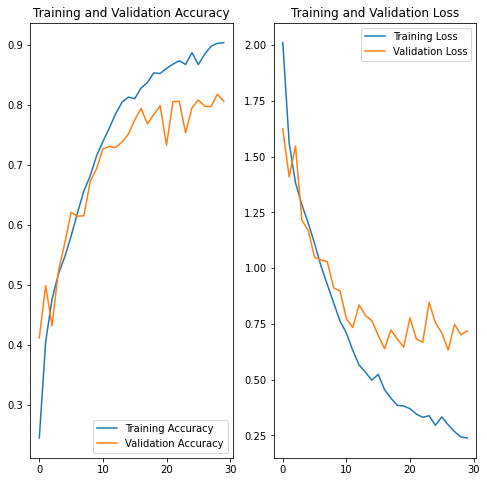

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [126]:
#Load test data set from the test folder
test_ds = image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123
    )

Found 118 files belonging to 9 classes.


In [128]:
# Predict classes using the test data
predictions = model.predict(test_ds)

In [138]:
pred_class_dist = np.zeros(9)
for i in predictions:
  indx = np.where(i[:]==max(i))
  pred_class_dist[indx[0]]+=1
print(pred_class_dist)

[ 8. 17.  5. 10. 47. 24.  0.  5.  2.]


In [140]:
# find the actual test class distribution
test_class_dist = np.zeros(9)
for i in test_ds.as_numpy_iterator():
  for x in i[1]:
    test_class_dist[x] +=1
print(test_class_dist)

[16. 16. 16. 16. 16. 16.  3. 16.  3.]


In [141]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [143]:
# The accuracy of predicting melanoma is
pred_class_dist[3]/test_class_dist[3]

0.625